In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import os

In [3]:
items = os.listdir('sensor_data')
csv_items = list(filter(lambda name: name[-4:] == '.csv', items))
filename = max(csv_items)

In [5]:
data = pd.read_csv('sensor_data/'+ filename)

In [9]:
data_lef = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_left.csv')
data_rig = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_right.csv')

In [7]:
# X_train = np.load('X_train.data.npy')
# y_train = np.load('y_train.data.npy')

# from sklearn import svm
# kernel_svm = svm.SVC(kernel='rbf',C=10, gamma=1)
# kernel_svm.fit(X_train, y_train)

# joblib.dump(kernel_svm, 'svm_classification.model') 

In [10]:
def predict_data(data, window_size):
    n_label=7
    #model = joblib.load('svm_classification.model') 
    model = joblib.load('decisionTree.model') 

    data_roll = data_roll = data.iloc[:,data.columns.get_loc('video_aboutTime')+1:].rolling(window=window_size).mean()
    data_roll = data_roll[window_size-1:]
    data.loc[window_size-1:,'label'] = model.predict(data_roll.values)
    print ('data_size:', len(data_roll))
    
    return data 

In [11]:
from sklearn import preprocessing
import numpy as np

def pre_processing_sig(data):
    for i in range(data.columns.get_loc('imu_temp'),len(data.columns)):
        data.iloc[:,i] = preprocessing.scale(data.iloc[:,i].values)

    from datetime import timedelta

    data.timestamp = pd.to_datetime(data.timestamp, unit='s')
    data.timestamp = data.timestamp.dt.tz_localize('UTC').dt.tz_convert('Asia/Taipei')

    data.wall_time= pd.to_datetime(data.wall_time, format='%Y-%m-%d_%H%M%S')

    data.loc[:, 'time_difference'] = data.wall_time-data.wall_time[0]

    data.loc[:, 'video_aboutTime'] = data.time_difference + timedelta(minutes=0, seconds=0)
    data.video_aboutTime = pd.to_datetime(data.video_aboutTime).dt.strftime('%M:%S')
    data = data[['key', 'timestamp', 'wall_time', 'time_difference',
       'video_aboutTime', 'imu_temp', 'imu_ax', 'imu_ay',
       'imu_az', 'imu_gx', 'imu_gy', 'imu_gz', 'msu_ax', 'msu_ay',
       'msu_az', 'baro_temp', 'baro']]
    return data

In [12]:
def plot_sig_by_videoTime_label(LorR, start_time, end_time, data=None):
    if LorR=='L':
        data = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_labeled_left.csv')
    elif LorR=='R':
        data = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_labeled_right.csv')
    elif LorR=='All': 
        data = data[:]
        data.rename(columns={'predict': 'label'}, inplace=True)
    data_part = data[(data.video_aboutTime>=start_time)&(data.video_aboutTime<=end_time)]
    data_setIndex = data_part.set_index('key')
    colors=['gray','b','g','r','c','m','y','orange','fuchsia']
    labels=['0. No nabel',
            '1.Spin by hand',
            '2. Remove with screws',
            '3. Screw with screws',
            '4. Rotate the object with both hands',
            '5. Pick up the object with one hand',
            '6. Put the screws up',
            '7. Put the screws sideways',
            '8. Weird!']
    for i in range(data_setIndex.columns.get_loc('video_aboutTime')+1, data_setIndex.columns.get_loc('baro')+1):
        fig = plt.figure(figsize=(25,5))
        ax1 = plt.subplot(1,1,1)
        plt.title(data_setIndex.columns[i])
        ax1.locator_params(nbins=20, axis='x')
        
        for j in range(0,8+1):
            if j==0:
                ax1.plot(data_setIndex.iloc[:,i], marker='.', color=colors[j], label=labels[j])
            else:
                data_setIndex_L = data_setIndex[data_setIndex.label==j]                                                    #<-
                labeled_data_L_G = data_setIndex_L.groupby(data_setIndex_L.index.to_series().diff().ne(1).cumsum()).groups #<-
                if len(labeled_data_L_G)==0:
                    ax1.plot(data_setIndex_L.iloc[:,i], marker='.', color=colors[j], label=labels[j])
                else:
                     for k, group in labeled_data_L_G.iteritems():                                                                  #<-
                        if k==1:
                            ax1.plot(data_setIndex_L.loc[group].iloc[:,i], marker='.', color=colors[j], label=labels[j]) #data_setIndex[data_setIndex['label']==j].iloc[:,i],
                        else:
                            ax1.plot(data_setIndex_L.loc[group].iloc[:,i], marker='.', color=colors[j], label='')
                            #data_setIndex[data_setIndex['label']==j].iloc[:,i],

        # Set scond x-axis
        ax2 = ax1.twiny()
        x_stick_data = data_part.groupby('video_aboutTime').first()['key']
        D_x_stick = [(len(x_stick_data)/19) if (len(x_stick_data)/19)!=0 else 1][0]
        ax2_values = x_stick_data[::D_x_stick]

        ### set same xlim(x_board), ax2 xlim not from 0 to len(data)
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(ax2_values)
        ax2.set_xticklabels(ax2_values.index)

        ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
        ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
        ax2.spines['bottom'].set_position(('outward', 36))
        #ax2.locator_params(nbins=30, axis='x')

        
        ax1.legend()
        plt.show()

In [13]:
data_lef = pre_processing_sig(data_lef)
data_rig = pre_processing_sig(data_rig)

window_size=15
data_lef = predict_data(data_lef, window_size)
data_rig = predict_data(data_rig, window_size)

data_lef.to_csv('20180926_basic_movement_Chi-Lan_IMU_predicted_left.csv', index=False)
data_rig.to_csv('20180926_basic_movement_Chi-Lan_IMU_predicted_right.csv', index=False)


C:\Users\user1\Anaconda2\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


('data_size:', 35057)
('data_size:', 35872)


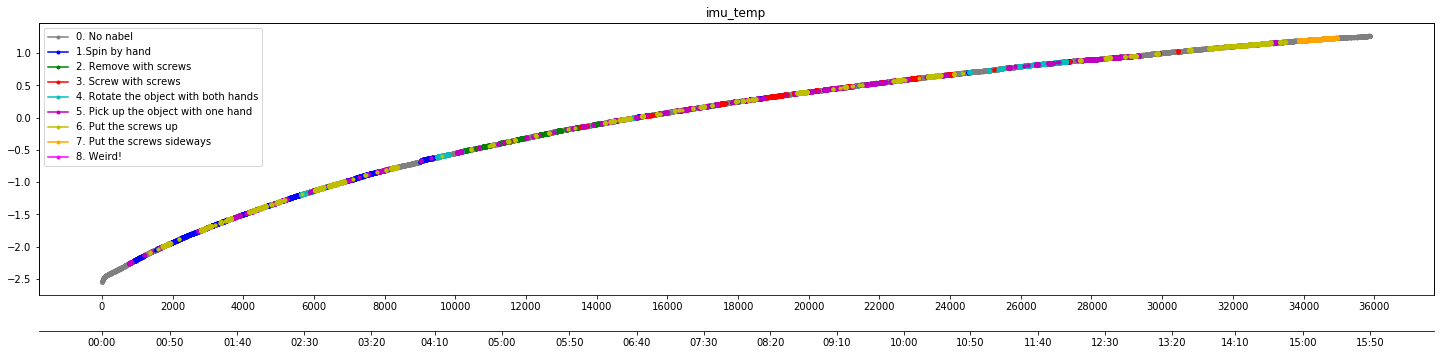

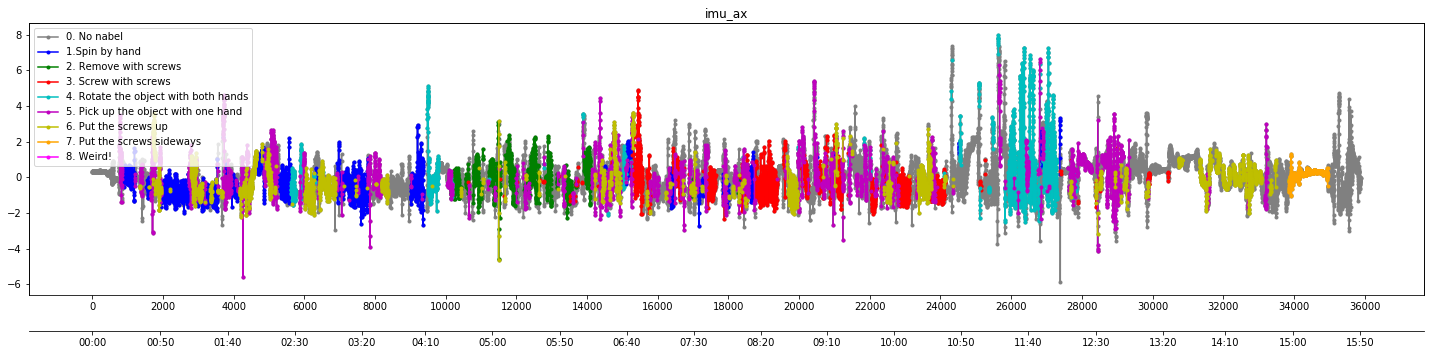

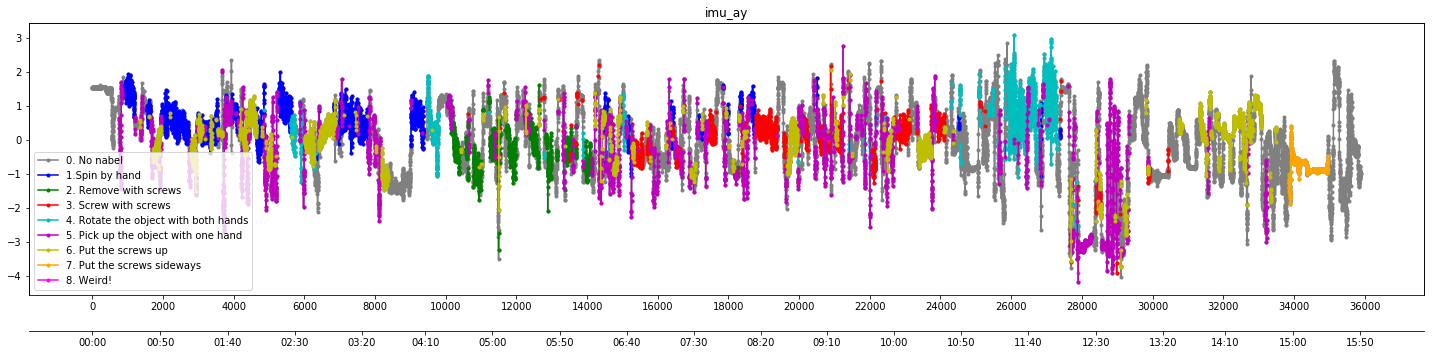

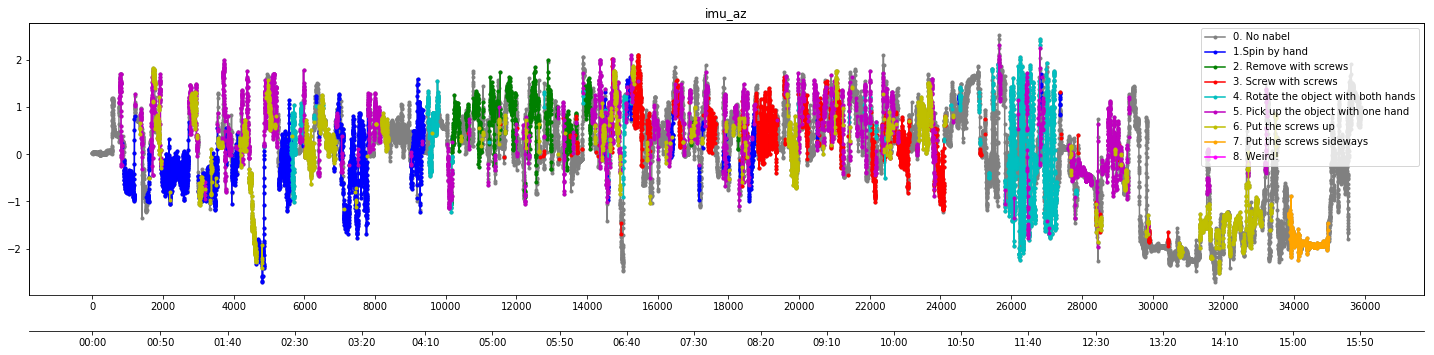

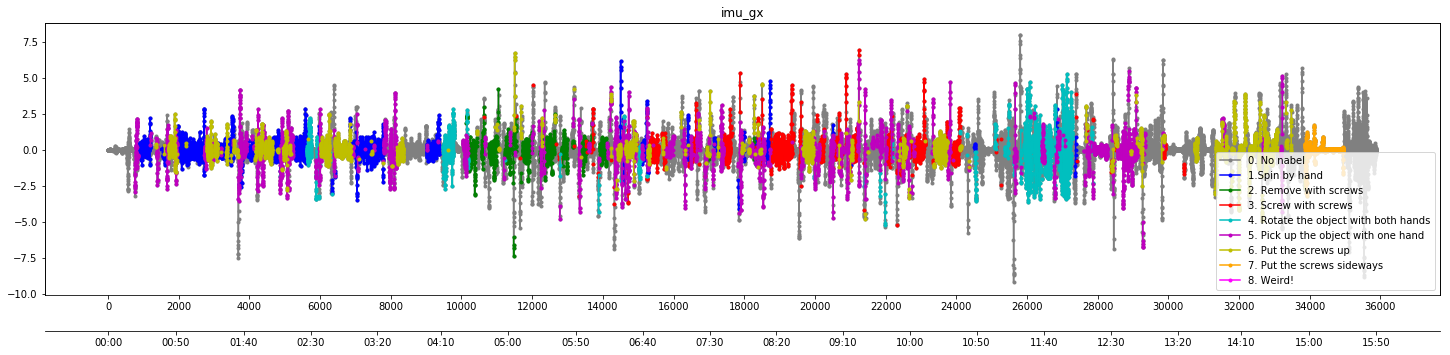

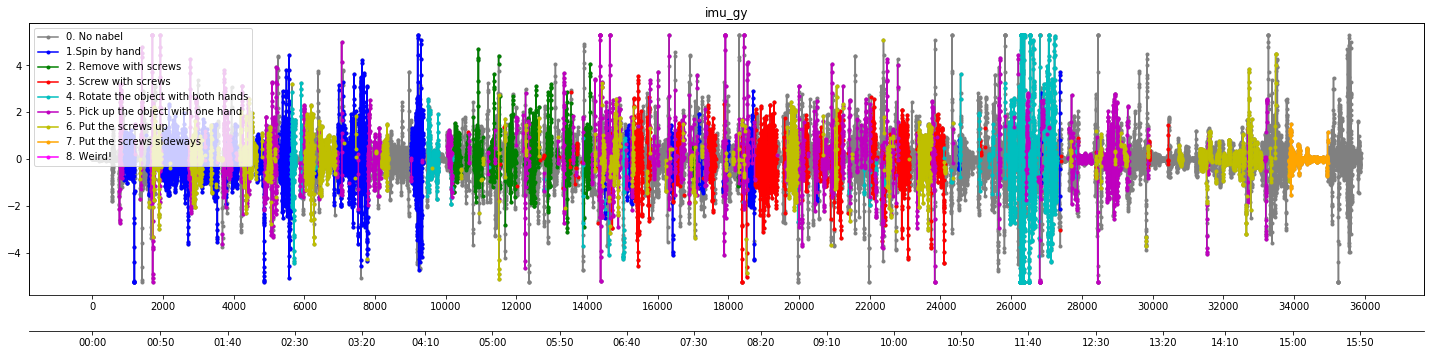

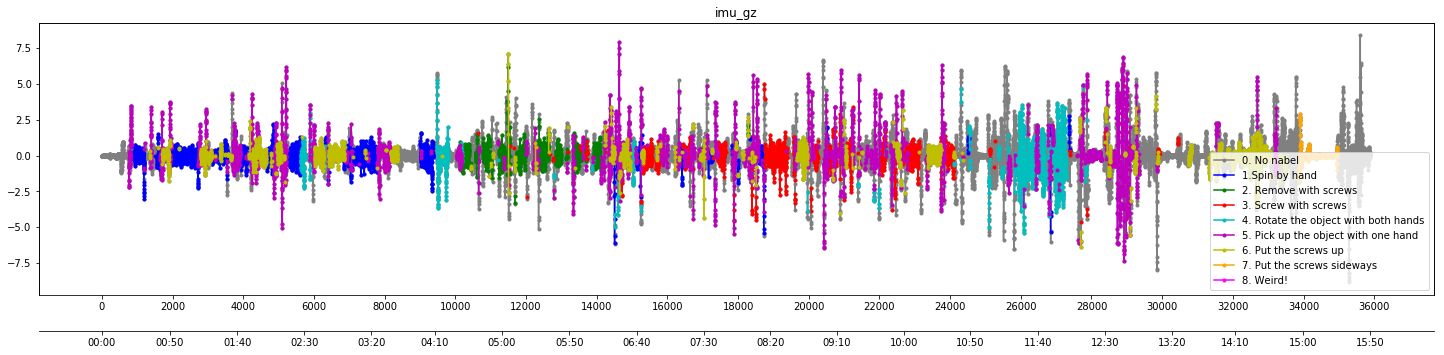

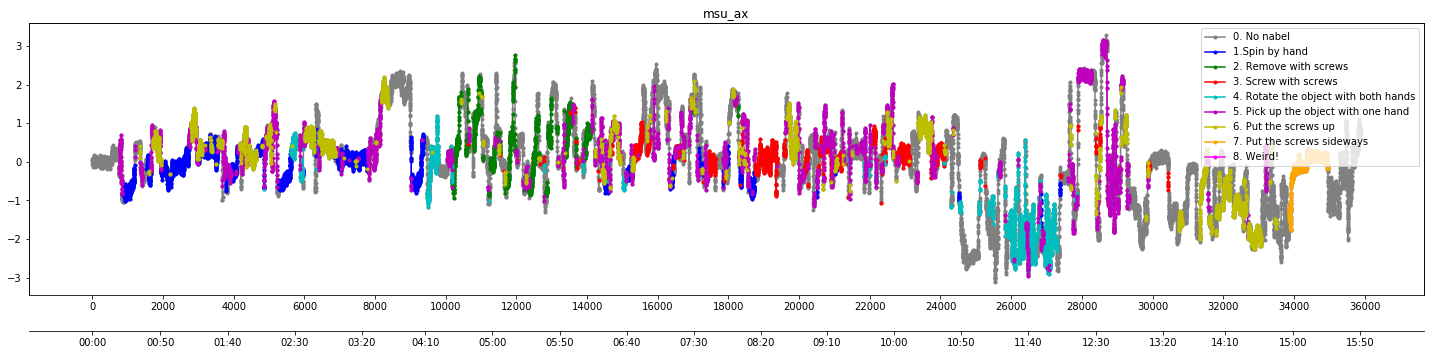

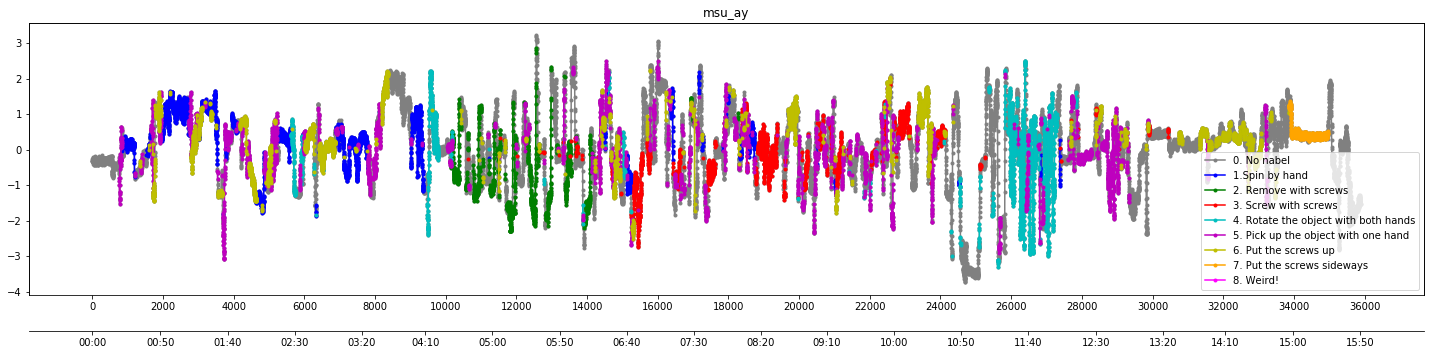

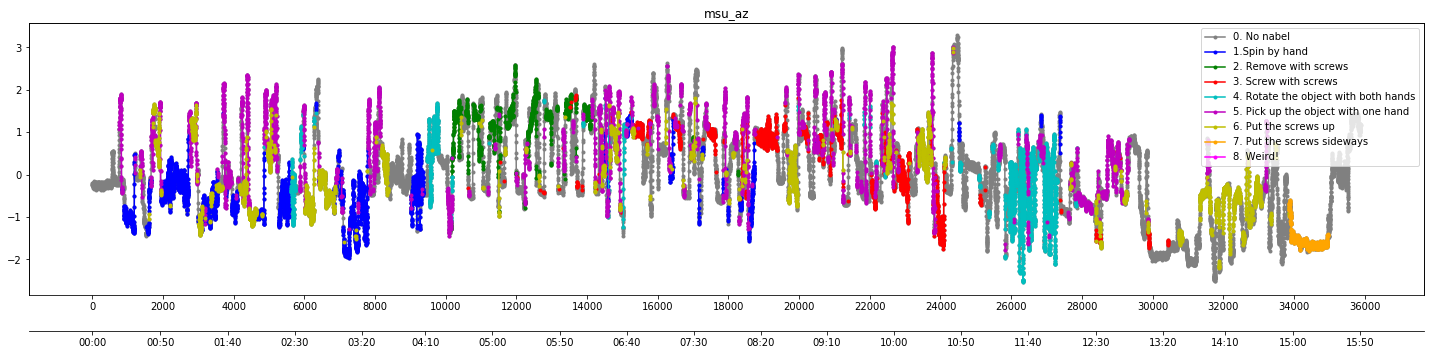

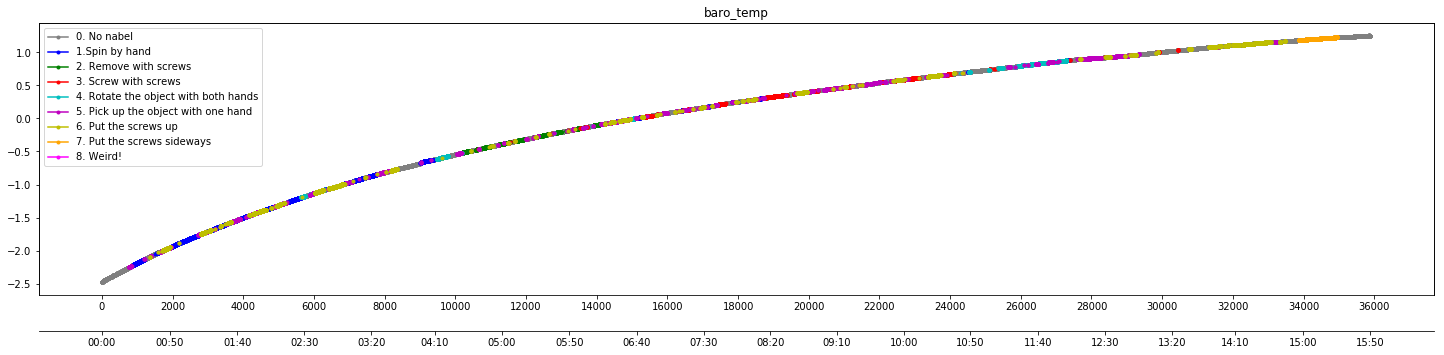

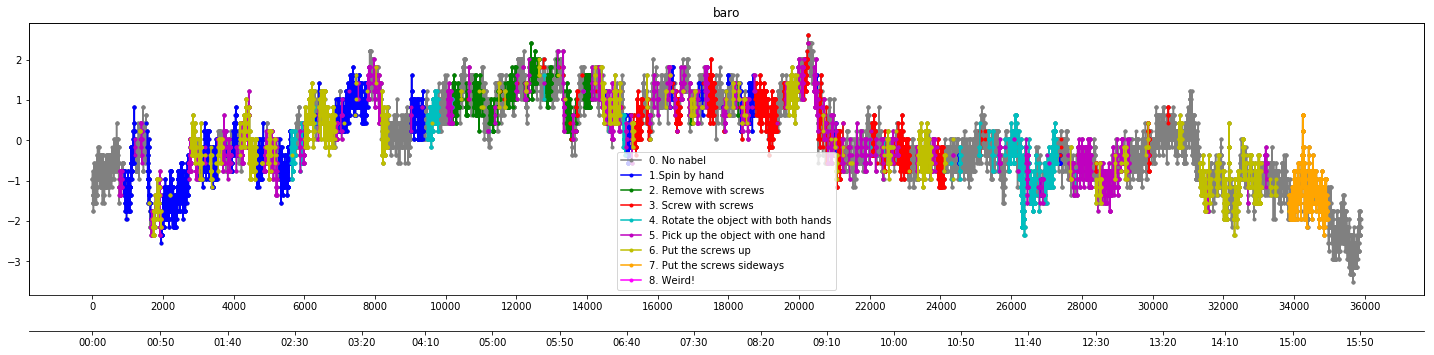

In [14]:
#data = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_predicted_left.csv')
data = pd.read_csv('20180926_basic_movement_Chi-Lan_IMU_predicted_right.csv')

plot_sig_by_videoTime_label('All', '00:00', '50:00', data=data)